In [39]:
!pip install accelerate

In [40]:
!pip install transformers

In [41]:
!pip install kaggle

In [42]:
from google.colab import files
files.upload()

{}

In [43]:
# Here I'll use the kaggle dataset from Commolit Readability Competition https://www.kaggle.com/c/commonlitreadabilityprize/data
# At first let me Mount my drive to get the dataset
HOME_PATH = "/content"
%cd "$HOME_PATH"
from google.colab import drive 
drive.mount("/content/drive")
# Kaggle dataset path
KAGGLE_PATH = "/content/drive/My Drive/Data Science/data/"
DATASET_PATH = "/content/drive/My Drive/Data Science/data/commonlitreadabilityprize/"

/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
#!mkdir ~/.kaggle
!cp "/content/drive/My Drive/Data Science/data/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c commonlitreadabilityprize

  0% 0.00/1.13M [00:00<?, ?B/s]
100% 1.13M/1.13M [00:00<00:00, 79.1MB/s]
  0% 0.00/108 [00:00<?, ?B/s]
100% 108/108 [00:00<00:00, 104kB/s]
  0% 0.00/6.79k [00:00<?, ?B/s]
100% 6.79k/6.79k [00:00<00:00, 6.55MB/s]


In [46]:
!mkdir input
!unzip train.csv.zip -d input
#!unzip file.zip -d input


mkdir: cannot create directory ‘input’: File exists
Archive:  train.csv.zip
replace input/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [30]:
!pip install colorama

In [31]:
import os
import gc
import sys
import math
import time
import tqdm
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from accelerate import Accelerator
from transformers import (AutoModel,AutoConfig,
                          AutoTokenizer,get_cosine_schedule_with_warmup)
from colorama import Fore, Back, Style
r_ = Fore.RED
b_ = Fore.BLUE
c_ = Fore.CYAN
g_ = Fore.GREEN
y_ = Fore.YELLOW
m_ = Fore.MAGENTA
sr_ = Style.RESET_ALL


In [10]:
train_data = pd.read_csv('input/train.csv')
test_data = pd.read_csv('input/test.csv')
#sample = pd.read_csv('../input/commonlitreadabilityprize/sample_submission.csv')

train_data['excerpt'] = train_data['excerpt'].apply(lambda x: x.replace('\n',''))

num_bins = int(np.floor(1 + np.log2(len(train_data))))
train_data.loc[:,'bins'] = pd.cut(train_data['target'],bins=num_bins,labels=False)

bins = train_data.bins.to_numpy()
target = train_data.target.to_numpy()

def rmse_score(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

In [11]:
num_bins

12

In [12]:
train_data.head()

,id,url_legal,license,excerpt,target,standard_error,bins
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,7
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,7
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,6
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,5
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,8


In [13]:
target

array([-0.34025912, -0.31537234, -0.58011797, ...,  0.25520938,
       -0.21527918,  0.30077875])

In [22]:
config = {
    'lr': 2e-5,
    'wd':0.01,
    'batch_size':16,
    'valid_step':10,
    'max_len':256,
    'epochs':3,
    'nfolds':5,
    'seed':42,
    'model_path':f'{DATASET_PATH}/clrp_roberta_base', # Mention the Model path 
}

for i in range(config['nfolds']):
    os.makedirs(f'model{i}',exist_ok=True)

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=config['seed'])

train_data['Fold'] = -1
kfold = StratifiedKFold(n_splits=config['nfolds'],shuffle=True,random_state=config['seed'])
for k , (train_idx,valid_idx) in enumerate(kfold.split(X=train_data,y=bins)):
    train_data.loc[valid_idx,'Fold'] = k

In [23]:
train_data.head()

,id,url_legal,license,excerpt,target,standard_error,bins,Fold
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,7,0
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,7,2
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,6,3
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,5,2
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,8,1


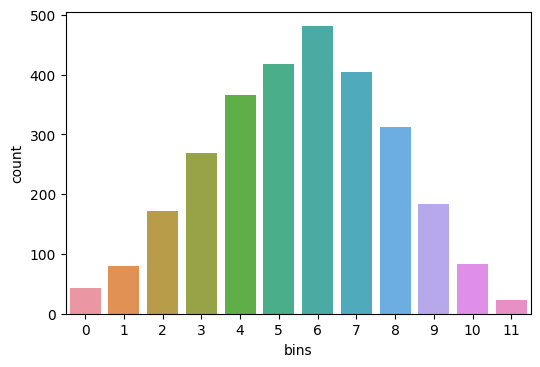

In [24]:
plt.figure(dpi=100)
sns.countplot(train_data.bins);

In [25]:
class CLRPDataset(Dataset):
    def __init__(self,df,tokenizer,max_len=128):
        self.excerpt = df['excerpt'].to_numpy()
        self.targets = df['target'].to_numpy()
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        
        target = torch.tensor(self.targets[idx],dtype=torch.float) 
        return encode, target
    
    def __len__(self):
        return len(self.excerpt)

In [26]:
class AttentionHead(nn.Module):
    def __init__(self, in_features, hidden_dim):
        super().__init__()
        self.in_features = in_features
        self.middle_features = hidden_dim
        self.W = nn.Linear(in_features, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        self.out_features = hidden_dim

    def forward(self, features):
        att = torch.tanh(self.W(features))
        score = self.V(att)
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector

In [27]:
class Model(nn.Module):
    def __init__(self,path):
        super(Model,self).__init__()
        self.roberta = AutoModel.from_pretrained(path)  
        self.config = AutoConfig.from_pretrained(path)
        self.head = AttentionHead(self.config.hidden_size,self.config.hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(self.config.hidden_size,1)

    def forward(self,**xb):
        x = self.roberta(**xb)[0]
        x = self.head(x)
        x = self.dropout(x)
        x = self.linear(x)
        return x

In [28]:
def run(fold,verbose=True):
    
    def loss_fn(outputs,targets):
        outputs = outputs.view(-1)
        targets = targets.view(-1)
        return torch.sqrt(nn.MSELoss()(outputs,targets))
    
    def train_and_evaluate_loop(train_loader,valid_loader,model,loss_fn,optimizer,epoch,fold,best_loss,valid_step=10,lr_scheduler=None):
        train_loss = 0
        for i, (inputs1,targets1) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            inputs1 = {key:val.reshape(val.shape[0],-1) for key,val in inputs1.items()}
            outputs1 = model(**inputs1)
            loss1 = loss_fn(outputs1,targets1)
            loss1.backward()
            optimizer.step()
            
            train_loss += loss1.item()
            
            if lr_scheduler:
                lr_scheduler.step()
            
            #evaluating for every valid_step
            if (i % valid_step == 0) or ((i + 1) == len(train_loader)):
                model.eval()
                valid_loss = 0
                with torch.no_grad():
                    for j, (inputs2,targets2) in enumerate(valid_loader):
                        inputs2 = {key:val.reshape(val.shape[0],-1) for key,val in inputs2.items()}
                        outputs2 = model(**inputs2)
                        loss2 = loss_fn(outputs2,targets2)
                        valid_loss += loss2.item()
                     
                    valid_loss /= len(valid_loader)
                    if valid_loss <= best_loss:
                        if verbose:
                            print(f"epoch:{epoch} | Train Loss:{train_loss/(i+1)} | Validation loss:{valid_loss}")
                            print(f"{g_}Validation loss Decreased from {best_loss} to {valid_loss}{sr_}")

                        best_loss = valid_loss
                        torch.save(model.state_dict(),f'./model{fold}/model{fold}.bin')
                        tokenizer.save_pretrained(f'./model{fold}')
                        
        return best_loss
    
    accelerator = Accelerator()
    print(f"{accelerator.device} is used")
    
    x_train,x_valid = train_data.query(f"Fold != {fold}"),train_data.query(f"Fold == {fold}")
    
    tokenizer = AutoTokenizer.from_pretrained(config['model_path'])
    model = Model(config['model_path'])

    train_ds = CLRPDataset(x_train,tokenizer,config['max_len'])
    train_dl = DataLoader(train_ds,
                        batch_size = config["batch_size"],
                        shuffle=True,
                        num_workers = 4,
                        pin_memory=True,
                        drop_last=False)

    valid_ds = CLRPDataset(x_valid,tokenizer,config['max_len'])
    valid_dl = DataLoader(valid_ds,
                        batch_size = config["batch_size"],
                        shuffle=False,
                        num_workers = 4,
                        pin_memory=True,
                        drop_last=False)

    optimizer = optim.AdamW(model.parameters(),lr=config['lr'],weight_decay=config['wd'])
    lr_scheduler = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps= 10 * len(train_dl))

    model,train_dl,valid_dl,optimizer,lr_scheduler = accelerator.prepare(model,train_dl,valid_dl,optimizer,lr_scheduler)

    print(f"Fold: {fold}")
    best_loss = 9999
    for epoch in range(config["epochs"]):
        print(f"Epoch Started:{epoch}")
        best_loss = train_and_evaluate_loop(train_dl,valid_dl,model,loss_fn,
                                            optimizer,epoch,fold,best_loss,
                                            valid_step=config['valid_step'],lr_scheduler=lr_scheduler)

In [32]:
for f in range(config['nfolds']):
    run(f)

cuda is used


Some weights of the model checkpoint at /content/drive/My Drive/Data Science/data/commonlitreadabilityprize//clrp_roberta_base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/drive/My Drive/Data Science/data/commonlitreadabilityprize//clrp_roberta_base and are newly initialized: ['robe

Fold: 0
Epoch Started:0
epoch:0 | Train Loss:1.1197649240493774 | Validation loss:1.175058947669135
Validation loss Decreased from 9999 to 1.175058947669135
epoch:0 | Train Loss:1.0996358394622803 | Validation loss:0.8710224098629422
Validation loss Decreased from 1.175058947669135 to 0.8710224098629422
epoch:0 | Train Loss:0.936041724114191 | Validation loss:0.7423608799775442
Validation loss Decreased from 0.8710224098629422 to 0.7423608799775442
epoch:0 | Train Loss:0.8414164108614768 | Validation loss:0.7125389642185636
Validation loss Decreased from 0.7423608799775442 to 0.7125389642185636
epoch:0 | Train Loss:0.7911472606892679 | Validation loss:0.611042882833216
Validation loss Decreased from 0.7125389642185636 to 0.611042882833216
epoch:0 | Train Loss:0.7608746627315146 | Validation loss:0.591389531062709
Validation loss Decreased from 0.611042882833216 to 0.591389531062709
epoch:0 | Train Loss:0.717272252580266 | Validation loss:0.5572404704160161
Validation loss Decreased fro

Some weights of the model checkpoint at /content/drive/My Drive/Data Science/data/commonlitreadabilityprize//clrp_roberta_base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/drive/My Drive/Data Science/data/commonlitreadabilityprize//clrp_roberta_base and are newly initialized: ['robe

Fold: 1
Epoch Started:0
epoch:0 | Train Loss:1.5247292518615723 | Validation loss:1.1474819895293977
Validation loss Decreased from 9999 to 1.1474819895293977
epoch:0 | Train Loss:1.0345157276500354 | Validation loss:0.791746167673005
Validation loss Decreased from 1.1474819895293977 to 0.791746167673005
epoch:0 | Train Loss:0.88670471736363 | Validation loss:0.7496366500854492
Validation loss Decreased from 0.791746167673005 to 0.7496366500854492
epoch:0 | Train Loss:0.817385575463695 | Validation loss:0.6563697730501493
Validation loss Decreased from 0.7496366500854492 to 0.6563697730501493
epoch:0 | Train Loss:0.7749397115009588 | Validation loss:0.6551410688294305
Validation loss Decreased from 0.6563697730501493 to 0.6551410688294305
epoch:0 | Train Loss:0.7155367311884145 | Validation loss:0.5971210789349344
Validation loss Decreased from 0.6551410688294305 to 0.5971210789349344
epoch:0 | Train Loss:0.690253110418857 | Validation loss:0.5847564968797896
Validation loss Decreased 

Some weights of the model checkpoint at /content/drive/My Drive/Data Science/data/commonlitreadabilityprize//clrp_roberta_base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/drive/My Drive/Data Science/data/commonlitreadabilityprize//clrp_roberta_base and are newly initialized: ['robe

Fold: 2
Epoch Started:0
epoch:0 | Train Loss:1.1979899406433105 | Validation loss:1.0941363374392192
Validation loss Decreased from 9999 to 1.0941363374392192
epoch:0 | Train Loss:0.9811591072516008 | Validation loss:0.8574089051948653
Validation loss Decreased from 1.0941363374392192 to 0.8574089051948653
epoch:0 | Train Loss:0.8485562589860731 | Validation loss:0.7263485714793205
Validation loss Decreased from 0.8574089051948653 to 0.7263485714793205
epoch:0 | Train Loss:0.814995008270915 | Validation loss:0.6696610003709793
Validation loss Decreased from 0.7263485714793205 to 0.6696610003709793
epoch:0 | Train Loss:0.7807160364646538 | Validation loss:0.6360939376884036
Validation loss Decreased from 0.6696610003709793 to 0.6360939376884036
epoch:0 | Train Loss:0.7572264519871258 | Validation loss:0.6315082808335623
Validation loss Decreased from 0.6360939376884036 to 0.6315082808335623
epoch:0 | Train Loss:0.7342596687901188 | Validation loss:0.5716784968972206
Validation loss Decr

Some weights of the model checkpoint at /content/drive/My Drive/Data Science/data/commonlitreadabilityprize//clrp_roberta_base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/drive/My Drive/Data Science/data/commonlitreadabilityprize//clrp_roberta_base and are newly initialized: ['robe

Fold: 3
Epoch Started:0
epoch:0 | Train Loss:1.1349283456802368 | Validation loss:1.207725602719519
Validation loss Decreased from 9999 to 1.207725602719519
epoch:0 | Train Loss:1.1081094362519004 | Validation loss:0.9174577477905486
Validation loss Decreased from 1.207725602719519 to 0.9174577477905486
epoch:0 | Train Loss:0.9712143057868594 | Validation loss:0.6808413888017336
Validation loss Decreased from 0.9174577477905486 to 0.6808413888017336
epoch:0 | Train Loss:0.8839635002997613 | Validation loss:0.5994292323788007
Validation loss Decreased from 0.6808413888017336 to 0.5994292323788007
epoch:0 | Train Loss:0.8313165481497602 | Validation loss:0.5788867763347096
Validation loss Decreased from 0.5994292323788007 to 0.5788867763347096
epoch:0 | Train Loss:0.7836327415997865 | Validation loss:0.5324643585417006
Validation loss Decreased from 0.5788867763347096 to 0.5324643585417006
epoch:0 | Train Loss:0.7604283665267515 | Validation loss:0.522263808382882
Validation loss Decreas

Some weights of the model checkpoint at /content/drive/My Drive/Data Science/data/commonlitreadabilityprize//clrp_roberta_base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/drive/My Drive/Data Science/data/commonlitreadabilityprize//clrp_roberta_base and are newly initialized: ['robe

Fold: 4
Epoch Started:0
epoch:0 | Train Loss:1.0219272375106812 | Validation loss:1.0334652993414137
Validation loss Decreased from 9999 to 1.0334652993414137
epoch:0 | Train Loss:0.9771076332439076 | Validation loss:0.7710481277770467
Validation loss Decreased from 1.0334652993414137 to 0.7710481277770467
epoch:0 | Train Loss:0.8600724112419855 | Validation loss:0.6730372649100091
Validation loss Decreased from 0.7710481277770467 to 0.6730372649100091
epoch:0 | Train Loss:0.8197273919659276 | Validation loss:0.6615686573916011
Validation loss Decreased from 0.6730372649100091 to 0.6615686573916011
epoch:0 | Train Loss:0.7197617741881824 | Validation loss:0.6399387700690163
Validation loss Decreased from 0.6615686573916011 to 0.6399387700690163
epoch:0 | Train Loss:0.672198485619951 | Validation loss:0.5368737586670451
Validation loss Decreased from 0.6399387700690163 to 0.5368737586670451
epoch:0 | Train Loss:0.6606603938717026 | Validation loss:0.5345427435305383
Validation loss Decr

In [33]:
!zip -r /content/model0.zip /content/model0/

  adding: content/model0/ (stored 0%)
  adding: content/model0/tokenizer_config.json (deflated 45%)
  adding: content/model0/model0.bin (deflated 7%)
  adding: content/model0/special_tokens_map.json (deflated 50%)
  adding: content/model0/tokenizer.json (deflated 59%)
  adding: content/model0/vocab.json (deflated 59%)
  adding: content/model0/merges.txt (deflated 53%)


In [34]:
!zip -r /content/model1.zip /content/model1/

  adding: content/model1/ (stored 0%)
  adding: content/model1/tokenizer_config.json (deflated 45%)
  adding: content/model1/special_tokens_map.json (deflated 50%)
  adding: content/model1/tokenizer.json (deflated 59%)
  adding: content/model1/vocab.json (deflated 59%)
  adding: content/model1/model1.bin (deflated 7%)
  adding: content/model1/merges.txt (deflated 53%)


In [35]:
!zip -r /content/model2.zip /content/model2/

  adding: content/model2/ (stored 0%)
  adding: content/model2/tokenizer_config.json (deflated 45%)
  adding: content/model2/model2.bin (deflated 7%)
  adding: content/model2/special_tokens_map.json (deflated 50%)
  adding: content/model2/tokenizer.json (deflated 59%)
  adding: content/model2/vocab.json (deflated 59%)
  adding: content/model2/merges.txt (deflated 53%)


In [36]:
!zip -r /content/model3.zip /content/model3/

  adding: content/model3/ (stored 0%)
  adding: content/model3/model3.bin (deflated 7%)
  adding: content/model3/tokenizer_config.json (deflated 45%)
  adding: content/model3/special_tokens_map.json (deflated 50%)
  adding: content/model3/tokenizer.json (deflated 59%)
  adding: content/model3/vocab.json (deflated 59%)
  adding: content/model3/merges.txt (deflated 53%)


In [37]:
!zip -r /content/model4.zip /content/model4/

  adding: content/model4/ (stored 0%)
  adding: content/model4/tokenizer_config.json (deflated 45%)
  adding: content/model4/special_tokens_map.json (deflated 50%)
  adding: content/model4/tokenizer.json (deflated 59%)
  adding: content/model4/vocab.json (deflated 59%)
  adding: content/model4/model4.bin (deflated 7%)
  adding: content/model4/merges.txt (deflated 53%)


In [38]:
from google.colab import files
files.download("/content/model0.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

files.download("/content/model1.zip")

In [47]:

files.download("/content/model2.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

files.download("/content/model3.zip")

In [48]:

files.download("/content/model4.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
|